# Import Libraries

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## System Info  and GPU growth

In [18]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = 30BFPC1AXW95
• Working Directory = C:\Users\knoor\OneDrive - Deakin University\Deep Learning with Python\HDeep_CapsNet\code\Training_and_Analysis\6_CU_BIRD
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : py38tf


In [19]:
# gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Training parameters

In [20]:
train_params = {"n_epochs" : 100,
                "batch_size": 128,
                "lr": 0.001, # Initial learning rate
                "momentum": 0.9,
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": keras.optimizers.SGD(learning_rate=train_params['lr'], 
                                                  momentum=train_params['momentum'], nesterov=True),
                "loss_function": 'categorical_crossentropy',
               }

# Load Dataset: CU BIRD

In [21]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.CU_Birds_200_2011(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = None, # 'mixup'
                                                                                  data_normalizing = None)

In [22]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

## Log Directory

In [23]:
directory = sysenv.log_dir('B_CNN')

# Model Architecture

In [24]:
model = models.B_CNN_Model_B(image_shape,
                             info['Num_Coarse'],info['Num_Medium'],info['Num_Fine'],
                             model_name='B_CNN_Model_B')

Model: "B_CNN_Model_B"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input[0][0]']                  
                                                                                                  
 batch_normalization_28 (BatchN  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 ormalization)                                                                                    
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization

                                                                                                  
 f_fc2_2 (Dense)                (None, 1024)         1049600     ['dropout_16[0][0]']             
                                                                                                  
 batch_normalization_33 (BatchN  (None, 256)         1024        ['c_fc_2[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_37 (BatchN  (None, 512)         2048        ['m_fc_2[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_41 (BatchN  (None, 1024)        4096        ['f_fc2_2[0][0]']                
 ormalizat

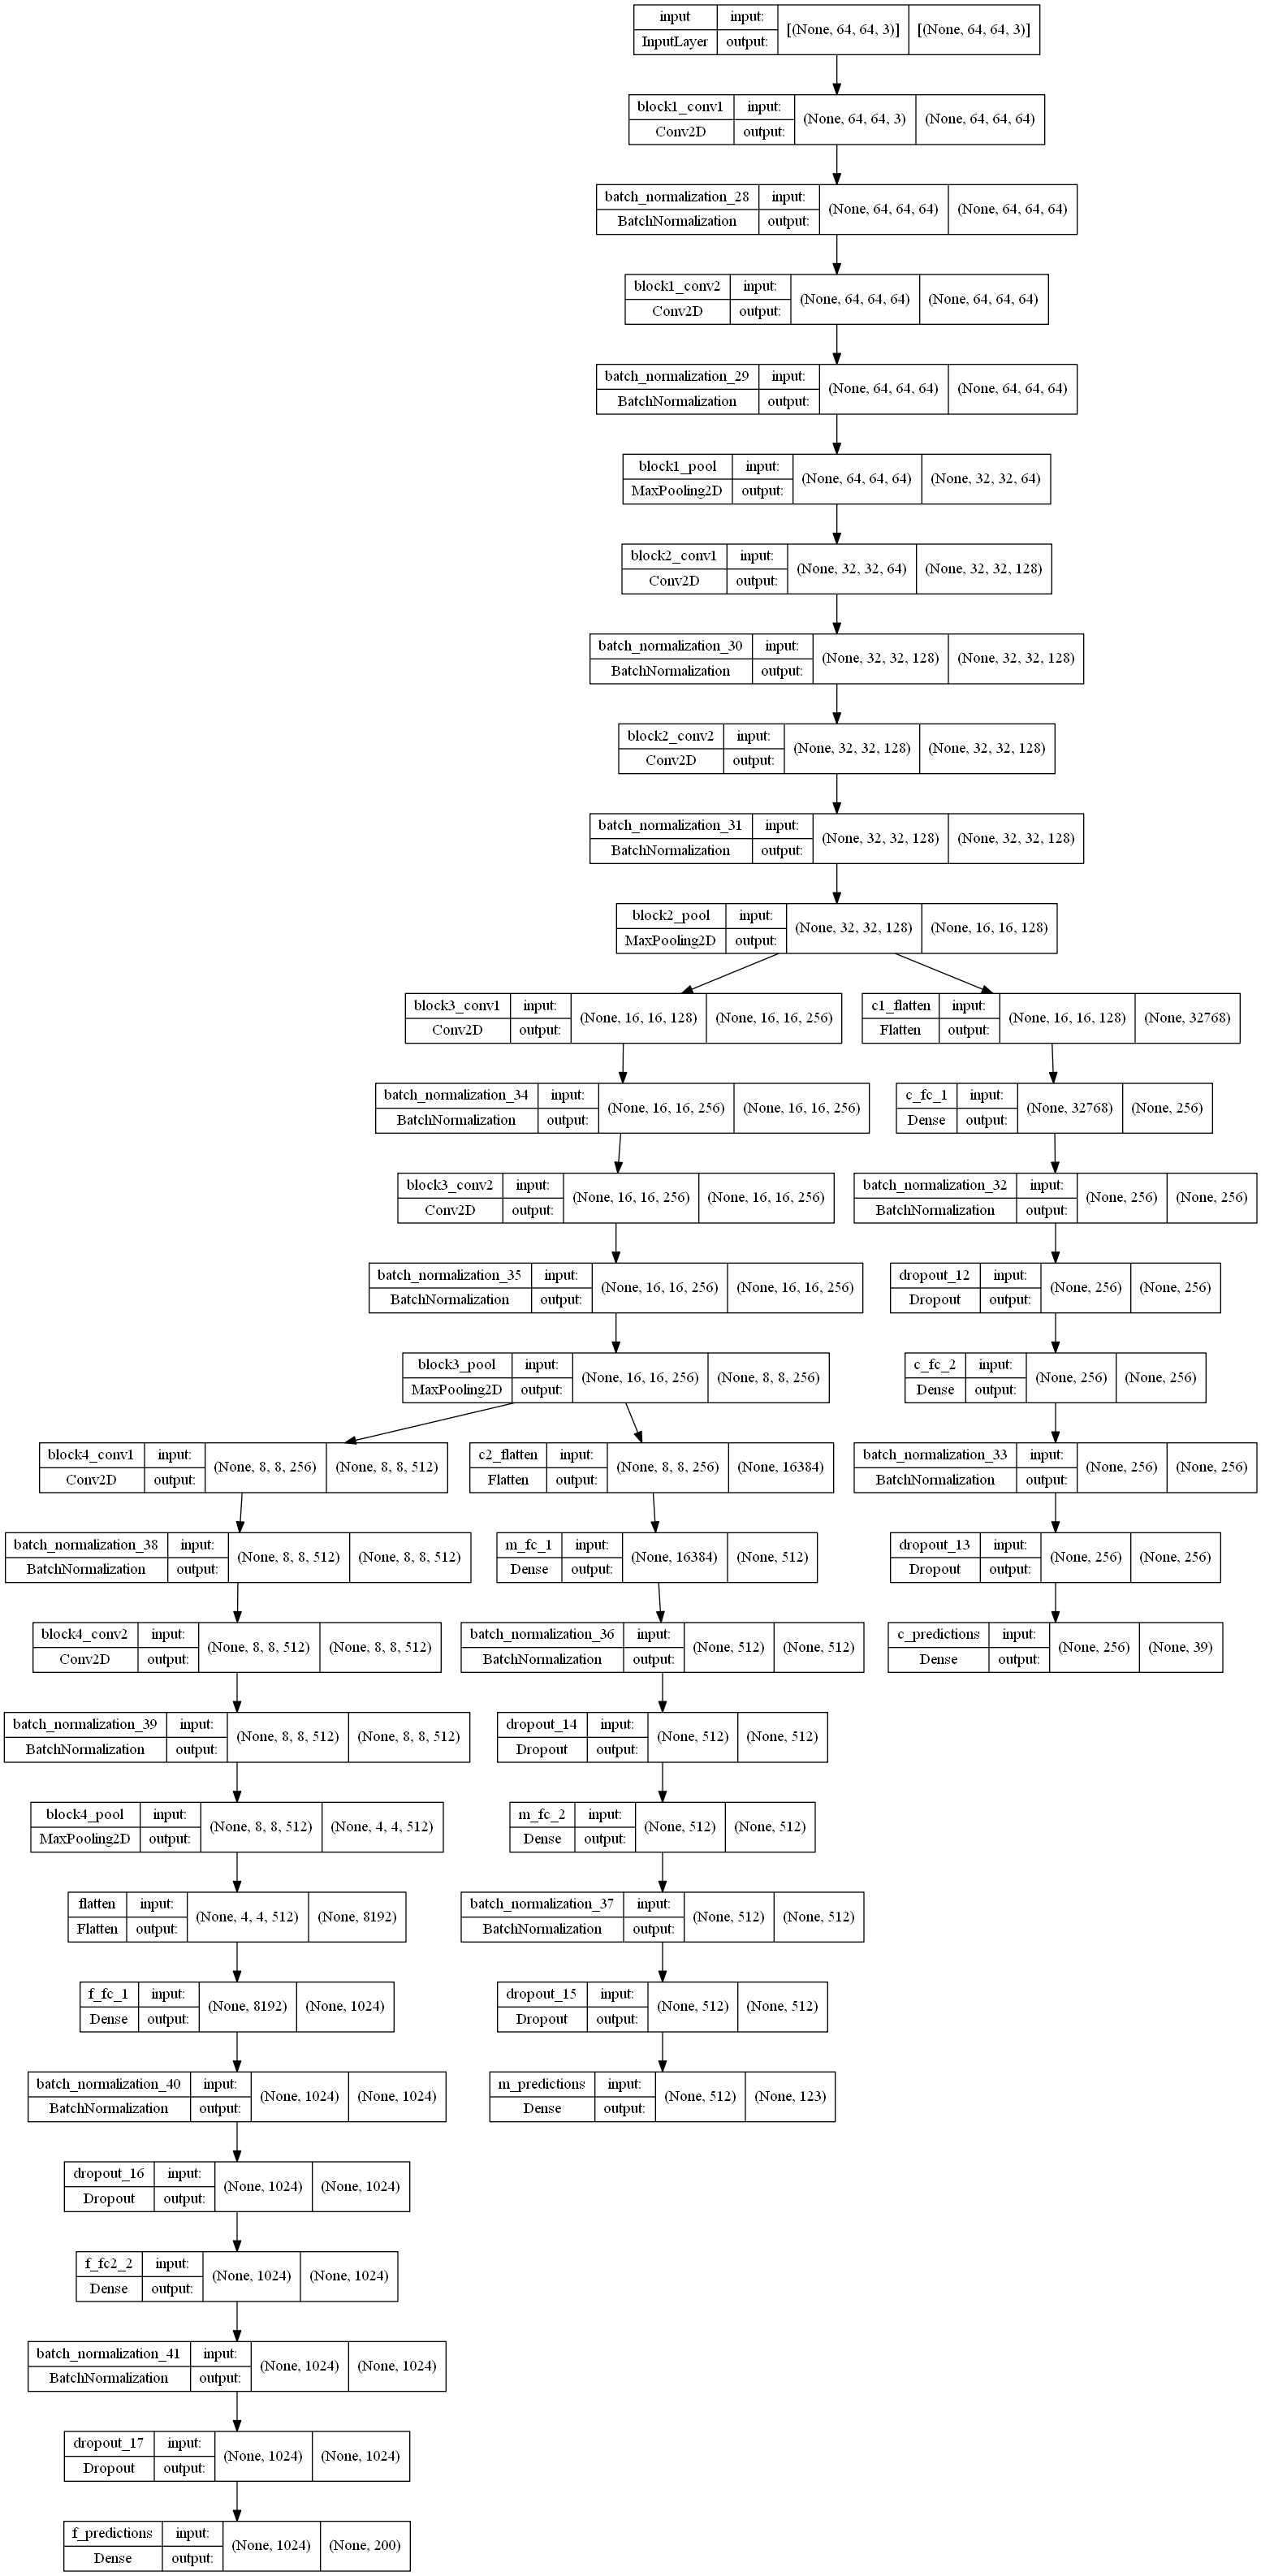

In [25]:
model.summary()
tf.keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

## Loss Weights Modifier

In [26]:
#----------------------- Initial values ---------------------------#
alpha = K.variable(value=0.98, dtype="float32", name="alpha") # A1 in paper
beta = K.variable(value=0.01, dtype="float32", name="beta") # A2 in paper
gamma = K.variable(value=0.01, dtype="float32", name="gamma") # A3 in paper

#----------------------- Update values using CallBacks ---------------------------#
class LossWeightsModifier(keras.callbacks.Callback):
    def __init__(self, alpha, beta, gamma):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 13:
            K.set_value(self.alpha, 0.1)
            K.set_value(self.beta, 0.8)
            K.set_value(self.gamma, 0.1)
        if epoch == 23:
            K.set_value(self.alpha, 0.1)
            K.set_value(self.beta, 0.2)
            K.set_value(self.gamma, 0.7)
        if epoch == 33:
            K.set_value(self.alpha, 0)
            K.set_value(self.beta, 0)
            K.set_value(self.gamma, 1)

## Learning Rate Scheduler

In [27]:
def scheduler(epoch):
    learning_rate_init = 0.001
    if epoch > 55:
        learning_rate_init = 0.0002
    if epoch > 70:
        learning_rate_init = 0.00005
    return learning_rate_init

## Compile Model

In [28]:
def get_compiled_model():
    model = models.B_CNN_Model_B(image_shape,
                             info['Num_Coarse'],info['Num_Medium'],info['Num_Fine'],
                             model_name='B_CNN_Model_B')
    
    model.compile(loss=model_params['loss_function'], 
              optimizer=model_params['optimizer'],
              loss_weights=[alpha, beta, gamma],
              metrics=['accuracy']
             )
    return model

In [29]:
strategy = models.multi_gpu_select('windows')

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = get_compiled_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


# Model Training

# Callbacks

In [30]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)
change_lr = keras.callbacks.LearningRateScheduler(scheduler)
change_lw = LossWeightsModifier(alpha, beta, gamma)
checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch_weights.h5',
                                             monitor='val_f_predictions_accuracy',
                                             save_best_only=True, save_weights_only=True,
                                             verbose=1)
cbks = [tb, log, change_lr, change_lw, checkpoint]

# Training

In [31]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
    print('Trained model weight Loaded')
except:
    history = model.fit(training_dataset,
                    epochs = train_params["n_epochs"],
                    validation_data = val_dataset,
                    callbacks = cbks,
                    verbose=1)
    model.save_weights(model_save_dir)

    

Trained model weight Loaded


# Model Analysis

In [18]:
history_dict = history.history

(0.0, 1.0)

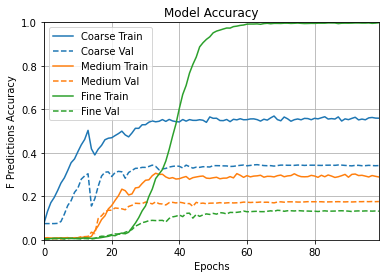

In [19]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "c_predictions_accuracy")
plotter.plot({"Medium": history}, metric = "m_predictions_accuracy")
plotter.plot({"Fine": history}, metric = "f_predictions_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 5.0)

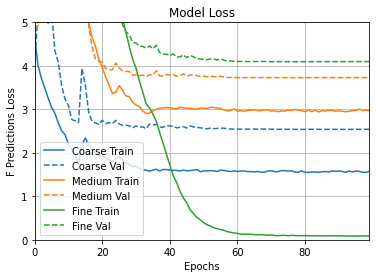

In [20]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "c_predictions_loss")
plotter.plot({"Medium": history}, metric = "m_predictions_loss")
plotter.plot({"Fine": history}, metric = "f_predictions_loss")
plt.title("Model Loss")
plt.ylim([0,5])

In [32]:
results = model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',model.metrics_names[n], '==>', results[n])
model_predictions = model.predict(test_dataset)

23/23 [==============================] - 10s 105ms/step - loss: 2.5683 - c_predictions_loss: 2.5409 - m_predictions_loss: 3.7274 - f_predictions_loss: 4.0982 - c_predictions_accuracy: 0.3400 - m_predictions_accuracy: 0.1760 - f_predictions_accuracy: 0.1329
1. loss ==> 2.5682904720306396
2. c_predictions_loss ==> 2.540851354598999
3. m_predictions_loss ==> 3.7274186611175537
4. f_predictions_loss ==> 4.098182678222656
5. c_predictions_accuracy ==> 0.34000691771507263
6. m_predictions_accuracy ==> 0.17604418098926544
7. f_predictions_accuracy ==> 0.13289609551429749


In [33]:
len(model_predictions[0]) == len(model_predictions[1]) == len(model_predictions[2])

True

In [34]:
dataset = {'x_test':[],
           'y_test_coarse':[],
           'y_test_medium':[],
           'y_test_fine':[]}
for x,y in test_dataset.unbatch().as_numpy_iterator():
    dataset['x_test'].append(x)
    dataset['y_test_coarse'].append(y[0])
    dataset['y_test_medium'].append(y[1])
    dataset['y_test_fine'].append(y[2])
    

In [35]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    image = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
                image.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
                image[i] = list(x[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
                image[i] = image[i] + list(x[i].numpy())
    return y_true, y_pred, image

In [36]:
predictions = []
predictions.append(predict_from_pipeline(model, test_dataset))

In [37]:
dataset= {'x_test':predictions[0][2][0], 
          'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [38]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 0  1  1 ...  0  0  1]
 [ 0 17  4 ...  0  0  0]
 [ 0  9 13 ...  0  0  0]
 ...
 [ 1  3  0 ...  2  6  0]
 [ 0  1  1 ...  0 39  2]
 [ 0  0  0 ...  0  3  7]]

  • MEDIUM LEVEL 
[[ 0  0  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  1  0 ... 39  0  3]
 [ 0  0  0 ...  0  6  0]
 [ 0  1  0 ...  5  0  5]]

  • FINE LEVEL 
[[2 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]

  • Classification Report 


  • COARSE LEVEL 


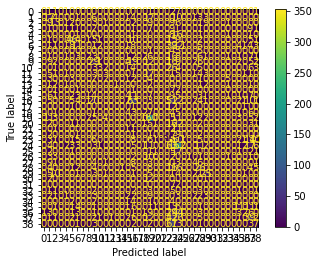

C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        14
           1    0.14912   0.25373   0.18785        67
           2    0.25490   0.19697   0.22222        66
           3    0.00000   0.00000   0.00000        35
           4    0.00000   0.00000   0.00000        29
           5    0.56790   0.46000   0.50829       100
           6    0.21569   0.09735   0.13415       113
           7    0.00000   0.00000   0.00000        15
           8    0.28571   0.03226   0.05797        62
           9    0.23967   0.24576   0.24268       118
          10    0.33333   0.05172   0.08955        58
          11    0.21429   0.06383   0.09836        47
          12    0.00000   0.00000   0.00000        23
          13    1.00000   0.08333   0.15385        12
          14    0.00000   0.00000   0.00000        12
          15    0.15385   0.06061   0.08696        66
          16    0.33333   0.31980   0.32642       197
          17    0.00000   0

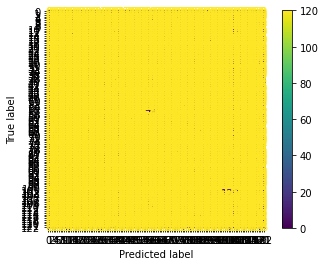

C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        20
           1    0.12963   0.25926   0.17284        27
           2    0.00000   0.00000   0.00000        11
           3    0.00000   0.00000   0.00000         9
           4    0.00000   0.00000   0.00000        14
           5    0.08738   0.21429   0.12414        42
           6    0.00000   0.00000   0.00000        13
           7    0.00000   0.00000   0.00000        15
           8    0.00000   0.00000   0.00000        16
           9    0.13158   0.31250   0.18519        16
          10    0.00000   0.00000   0.00000        16
          11    0.30000   0.18750   0.23077        16
          12    0.14286   0.05714   0.08163        35
          13    0.00000   0.00000   0.00000        17
          14    0.00000   0.00000   0.00000         9
          15    0.00000   0.00000   0.00000        41
          16    0.37500   0.30000   0.33333        10
          17    0.00000   0

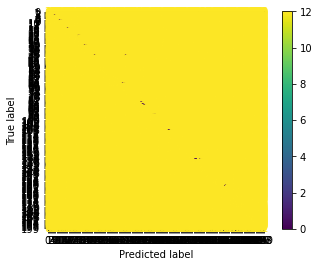

              precision    recall  f1-score   support

           0    0.09524   0.13333   0.11111        15
           1    0.00000   0.00000   0.00000        16
           2    0.08333   0.06250   0.07143        16
           3    0.11111   0.07692   0.09091        13
           4    0.00000   0.00000   0.00000         7
           5    0.12500   0.25000   0.16667         4
           6    0.31579   0.37500   0.34286        16
           7    0.11111   0.20000   0.14286        10
           8    0.06667   0.08333   0.07407        12
           9    0.14286   0.09091   0.11111        11
          10    0.09091   0.05882   0.07143        17
          11    0.42857   0.46154   0.44444        13
          12    0.19048   0.33333   0.24242        12
          13    0.22222   0.30769   0.25806        13
          14    0.00000   0.00000   0.00000        16
          15    0.30769   0.26667   0.28571        15
          16    0.30000   0.30000   0.30000        10
          17    0.10526   0

In [24]:
metrics.lvl_wise_metric(true_label,pred_label)

In [39]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.21648256817397307 
Hierarchical Recall = 0.3149234840639742 
Hierarchical F1-Score = 0.2527190141964046 
Consistency =  0.14739385571280636 
Exact Match =  0.03244735933724543
